# 소개
## 목표
* 트윗이 실제 재해 관련 내용인지 → 이진분류 (1 or 0)

## dataset 소개
* x: 트윗 / y: label
* training set, test set 나뉘어 있음.
* training set → 7613개 data(행) * 5개 features(열)

## Evaluation Metric (평가 지표)
* F score
  * = F1 score = F measure
  * 값: 0~1 / 클수록 좋음
  * 구하는 법
    * 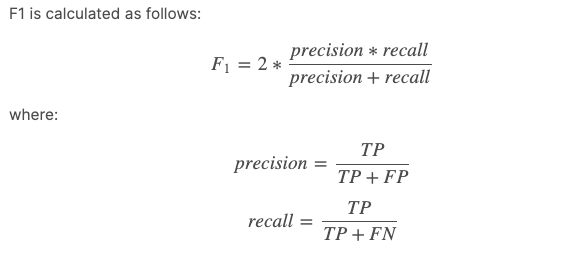
    * **precision** = **양성 판정한 것** 중 **진짜 양성**
    * **recall** = **진짜 양성** 중 **맞게 판정한 것**

# 코드

## 1. 라이브러리 import

In [1]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## dataset 불러오기

In [17]:
#Training data
train = pd.read_csv('../input/nlp-getting-started/train.csv') # Pandas 라이브러리 사용해서 불러옴
print('Training data shape: ', train.shape)
train.head() # 처음 5개 행을 출력 (Pandas 라이브러리 함수)

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
# Testing data 
test = pd.read_csv('../input/nlp-getting-started/test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 3. EDA (Exploratory Data Analysis)
* 정의
  * **데이터를 시각화, 요약 통계를 계산해봄** → 데이터가 어떻게 생겼나 훑어보며 초기 통찰을 얻는 과정
* 목적
  * **데이터의 구조 이해**: 데이터의 분포, 패턴, 관계 등을 파악합니다.
  * **이상치 탐지**: 데이터 내의 이상치(outlier)나 결측치(missing value)를 식별합니다.
  * **변수 간 관계 파악**: 각 변수 간의 상관 관계나 상호 작용을 분석합니다.
  * **데이터 전처리**: 데이터 정제 및 변환 과정을 계획합니다.

In [11]:
# 결측치(Missing values) 확인
print(train.isnull().sum()) # isnull() : 각 요소가 결측치인지 확인 / sum() : 각 열(column)별로 "true"(결측치 맞음) 값 개수 계산
print("-------------------")
print(test.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
-------------------
id             0
keyword       26
location    1105
text           0
dtype: int64


target
0    4342
1    3271
Name: count, dtype: int64




<Axes: xlabel='target', ylabel='count'>

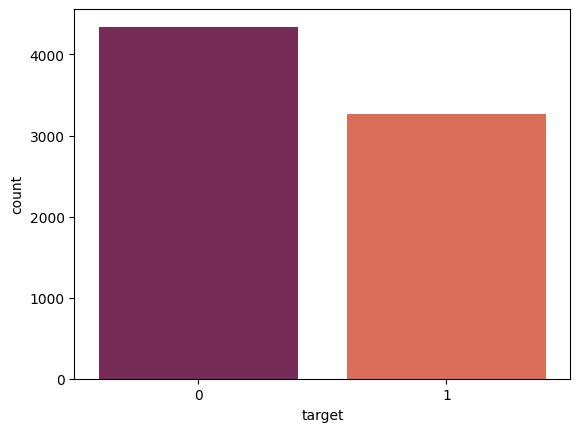

In [18]:
# Training set에서 target 열(=label)에 이상한 값 없나 확인
print(train['target'].value_counts()) # 값 몇 개인가 세보고

print("\n")
sns.barplot(x=train['target'].value_counts().index, y=train['target'].value_counts(), palette='rocket') # 그래프도 그려봄

In [23]:
# data의 text 칼럼 출력해보기

disaster_tweets = train[train['target']==1]['text']
print("재난 트윗 O : ", disaster_tweets.values[1])

non_disaster_tweets = train[train['target']==0]['text']
print("재난 트윗 X : ", non_disaster_tweets.values[1])

재난 트윗 O :  Forest fire near La Ronge Sask. Canada
재난 트윗 X :  I love fruits


<Axes: xlabel='count', ylabel='keyword'>

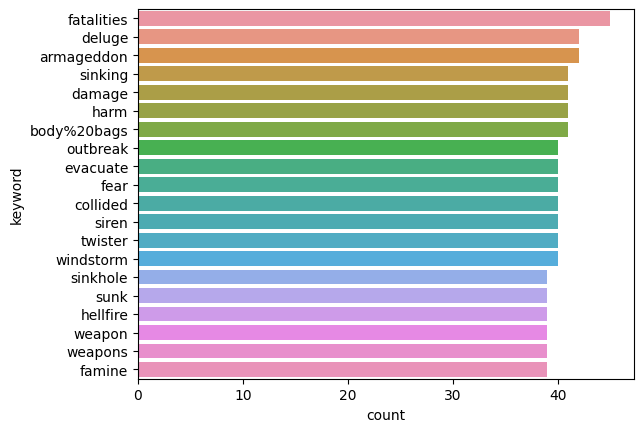

In [25]:
# data의 keyword 칼럼 출력해보기

sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20], orient='h') # training set의 상위 20개 키워드를 그래프로 출력

In [27]:
# 트윗에 'disaster' 키워드가 얼마나 나오는지, label별로 출력 

train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

target
1    102
0     40
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='location'>

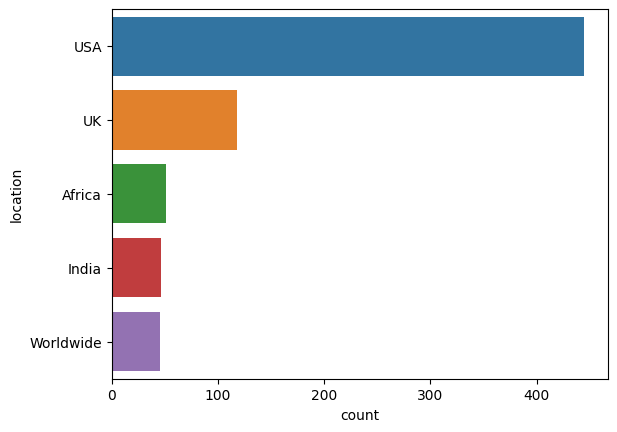

In [28]:
# data의 location 칼럼 출력해보기

train['location'].replace({'United States':'USA', # 지역 이름을 나라 이름으로 대체
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"}, inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index, x=train['location'].value_counts()[:5], orient='h')

## 4. Data 전처리 (Preprocessing)

***※ 전처리 방법을 전부 사용할 필요는 없음.***

*상황에 맞게 적절히, 아래 사진 참고*

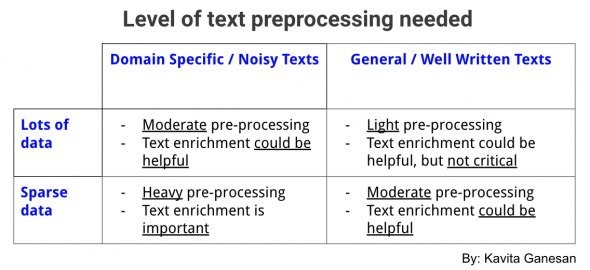

### 4-1) Data Cleaning

* **대소문자 통일** → 전부 대문자 or 전부 소문자
* **노이즈 제거** : ex) 구두점, 숫자값, 그 외 의미 없는 텍스트(\n)

In [4]:
# 일부 data 출력해서 간단히 확인
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [19]:
def clean_text(text):
    text = text.lower() # 소문자로 통일
    text = re.sub('\[.*?\]', '', text) # 대괄호 제거 → "[내용]"
    text = re.sub('https?://\S+|www\.\S+', '', text) # link 제거
    text = re.sub('<.*?>+', '', text) # HTML 태그 제거 → "<태그>"
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # 구두점 제거
    text = re.sub('\n', '', text) # 줄바꿈 제거
    text = re.sub('\w*\d\w*', '', text) # 숫자값 제거
    return text

# training set, test set에 모두 적용
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# 잘 됐나 확인
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

### 4-2) Tokenization
* 종류 (4가지)
  * **WhitespaceTokenizer** : 공백 기준
  * **TreebankWordTokenizer** : 구두점, 특수 문자를 고려
  * **WordPunctTokenizer** : 구두점 기준
  * **RegexpTokenizer** : 정규 표현식 사용. (ex: \w+ 패턴을 사용 → word만 추출)

* ex)

  * 실행결과
  
  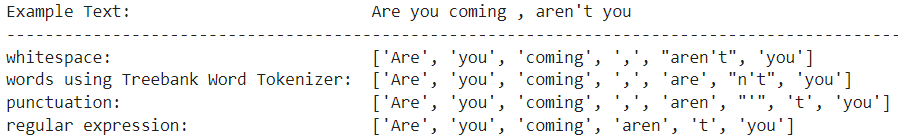

  * 코드
  
  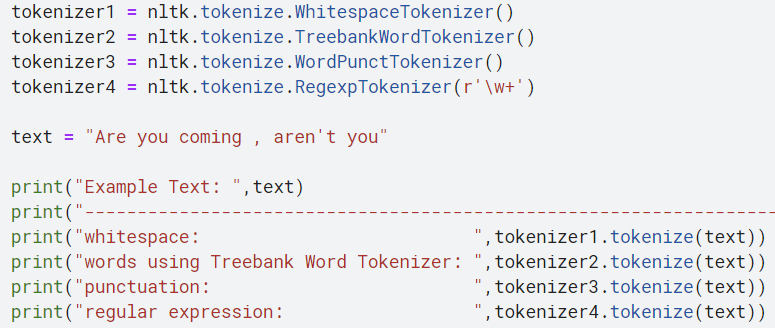

In [20]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') # tokenize 규칙 정하기

train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x)) # train set에 tokenization
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x)) # test set에 ~~~

# 잘 됐는지 확인
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

### 4-3) Stopword 제거
* **Stopword 제거** : 너무 일반적이라 의미 파악에 도움이 안 되는 단어.
  * 언어마다 다름. (ex: 영어 → a, the / and, or / is, have, do / if, while 등) 

In [21]:
# stopword 제거
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))

# 잘 됐나 확인
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


### 4-4) Token normalization
* **Stemming** : 용언의 활용형 → 기본형으로 통일
  * 단어의 의미를 고려하지 않고 단순히 접미사를 제거 ⇒ 종종 사전에 존재하지 않는 단어가 생성될 수 있음.
* **Lemmatization** : Stemming이랑 비슷한데, 더 정확함
  * 단어의 의미를 고려 ⇒ 항상 사전에 등재된 유효한 형태를 찾아냄.
  
ex)

실행 결과
  
  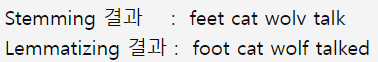
  
코드
  
  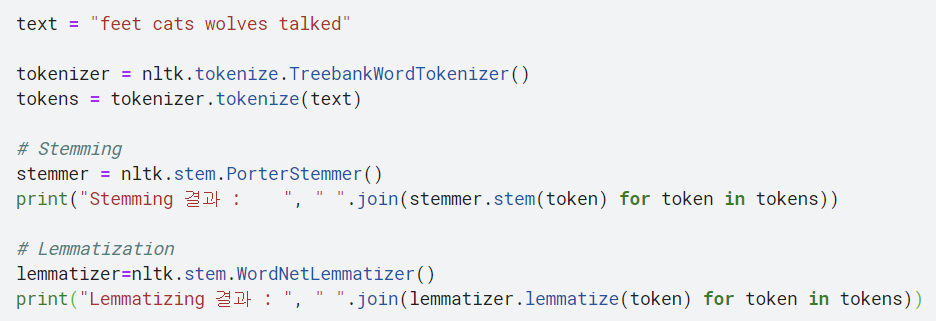

* **Parts of speech tagging** : 품사 태깅
* **bi-grams / tri-grams 생성** : 문장에서 연속적으로 나타나는 단어들을 몇 개씩 묶어서 하나의 단위로 처리하는 작업

### 4-5) 잘 됐는지 확인

In [29]:
def combine_text(list_of_text): # text 목록을 인수로 받아서 전부 띄어쓰기로 이어붙이는 함수
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))

# 잘 됐나 확인
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


### (+) 위의 전처리 과정 → 함수로 묶기. 재사용할 수 있게.

In [10]:
def text_preprocessing(text):

    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    
    return combined_text

## 5. tokens → vector 변환
### 방법1) Bag of Words 이용
* 코드 : scikit-learn의 CountVectorizer 사용
* vector의 행 : 각 트윗 / 열 : 각 단어

In [39]:
# vector로 변환
count_vectorizer = CountVectorizer()

train_vectors = count_vectorizer.fit_transform(train["text"])
test_vectors  = count_vectorizer.transform(test["text"]) # 두 함수 차이 : training set에 쓰는지, test set에 쓰는지

# 잘 됐나 확인
print(train_vectors[0]) # 위에서 구한 vector 변수는 대부분의 요소가 0인 "희소 행렬"이라, 0 아닌 값의 위치만 저장함.
print("---------------------")
print(train_vectors[0].todense()) # 이건 우리가 보기 쉽게 todense 메소드 써서 "밀집 행렬"로 바꿔준 것

  (0, 3629)	1
  (0, 11673)	1
  (0, 4388)	1
  (0, 8904)	1
  (0, 389)	1
  (0, 5490)	1
  (0, 15278)	1
---------------------
[[0 0 0 ... 0 0 0]]


### 방법2) TFIDF Features → Bag of Words 방식의 문제점 보완
* 문제점
  * 빈도 높은 단어가 항상 의미 있는 정보값을 갖는 건 아님. (ex: a, the / you, I 등)
  * 긴 문장에 짧은 문장보다 더 큰 가중치를 줌.
* 해결책
  * **TF-IDF** : 모든 문서에서 자주 나타나는 단어 → 추가로 패널티를 줌.

* TF-IDF (Term Frequency - Inverse Document Frequency)
  * **TF**
    * **클수록** 특정 문서 내에서 **빈도↑**
    * = (그 문서의 특정 단어 수)/(그 문서의 전체 단어 수)
  * **IDF**
    * **작을수록** 전체 문서 중 **빈도↑**
    * 그래서 Inverse ~~
    * = 1+log(전체 문서 수/특정 단어가 나타난 문서 수)

In [42]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

## 6. 모델 구축

### 6-1) Classifier 정하기

#### 시도1) Logistic Regression Classifier

In [44]:
# 모델이 데이터에 적합한지, 학습 없이 간단하게 평가해보기
clf = LogisticRegression(C=1.0) # 간단한 Logistic Regression 모델 생성 (C: 정규화 매개변수)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1") # train_vectors : 입력 data의 벡터 표현 / train["target"] : label / cv=5 : 5-fold 교차 검증 / scoring="f1" : 평가 지표로 F1 점수를 사용

# 평가지표 출력
print(scores)

# 모델 학습
clf.fit(train_vectors, train["target"])

[0.59865255 0.49611063 0.57166948 0.56290774 0.68789809]


LogisticRegression()

In [47]:
# 벡터 표현 :'단순 Bag of Words 방식' 대신 'TFIDF 방식'으로 만든 것을 사용
# 위에서 한 과정 반복
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
print(scores)

[0.57229525 0.49673203 0.54277829 0.46618106 0.64768683]


#### 시도2) Naives Bayes Classifier

In [48]:
# 모델이 데이터에 적합한지, 학습 없이 간단하게 평가해보기
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")

# 평가지표 출력
print(scores)

# 모델 학습
clf_NB.fit(train_vectors, train["target"])

[0.63149079 0.60675773 0.68575519 0.64341085 0.72505092]


MultinomialNB()

In [50]:
# 벡터 표현 : 'TFIDF 방식'으로 만든 것을 사용
# 위에서 한 과정 반복
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
print(scores)
clf_NB_TFIDF.fit(train_tfidf, train["target"])

[0.57590597 0.57092511 0.61135371 0.5962963  0.7393745 ]


MultinomialNB()

#### 시도3) XGBoost

In [53]:
# 모델이 데이터에 적합한지, 학습 없이 간단하게 평가해보기
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")

# 평가지표 출력
print(scores)

[0.49406688 0.37087379 0.43429637 0.3780359  0.52307692]


In [54]:
# 벡터 표현 : 'TFIDF 방식'으로 만든 것을 사용
# 위에서 한 과정 반복
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")

# 평가지표 출력
print(scores)

[0.47191011 0.36113837 0.42638623 0.38949672 0.52812202]


### 6-2) test set 사용해서 예측 → submission (제출) 만들기
* 모델 : clf_NB_TFIDF 사용
  * Naives Bayes Classifier 사용
  * 벡터 변환 시 TFIDF 방식 사용

In [57]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path) # 제출용 CSV 파일(빈 파일) 읽기
    sample_submission["target"] = model.predict(test_vectors) # 예측 수행
    sample_submission.to_csv("submission.csv", index=False) # 예측 결과를 파일에 쓰기 

submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
test_vectors = test_tfidf
submission(submission_file_path, clf_NB_TFIDF, test_vectors)